The CrosswordFiller needs two things as input: an empty crossword (which specifies the locations of black fields) and a vocabulary.

The vocabulary is a list of words that can be used in the crossword. For the final product, of course, the words in the crossword need to be connected to clues. This can be done post hoc, or the CrosswordFiller could be adapted to import a dictionary of words and clues, and export clues as part of the output.

As a bit of terminology:

A <b>crossword</b> is the actual puzzle, meaning the grid structure. The <b>solution</b> to a crossword is the grid completely filled out.

A crossword consists of <b>fields</b>. A field has a single <b>letter</b>. This is usually a single character in the strict sense, but Dutch crosswords count "IJ"  as a single letter. Fields that have no corresponding letter are called <b>black fields</b>.

Fields in crosswords have coordinates (X,Y). X coordinates are counted left to right, starting at 0. Y coordinates are counted top to bottom, starting at 0.

A <b>sequence</b> is a group of fields on a horizontal or vertical line that correspond to a single word in the solution. Each sequence has a corresponding clue.

A <b>word</b> is an ordered set of letters and an element of the vocabulary. A word can be filled into a sequence.

In [1]:
import random
import copy
import numpy as np
import nltk

## Vocabulary import

In [2]:
#use the NLTK words corpus as a filler vocabulary

nltkwords = nltk.corpus.words.words()
unfilteredvocab = [w.lower() for w in nltkwords]

vocab = []
for w in unfilteredvocab:
    if not '-' in w:
        vocab.append(w)
        

In [10]:
#use the words from the example crossword as a filler vocabulary

vocab = ['moeras', 'bleken', 
         'sara', 'reep', 
         'kt', 'miljoen', 'cd',
         'kat', 'atoom', 'tra', 
         'arts', 'ons', 'klit',
         'tu', 'do',
         'bereidvaardig',
         'lt', 'sp',
         'test', 'vos', 'step',
         'oer', 'meute', 'kei',
         'nl', 'uurwerk', 'lp',
         'snit', 'neon',
         'cruise', 'onecht',
         'mokka', 'tonic',
         'tarwemeel',
         'es', 'tt', 'sr', 'su',
         'ram', 'stelt', 'uni',
         'aria', 'uit', 'muis',
         'salto', 'verte',
         'jonkvrouw',
         'broos', 'steno',
         'leem', 'das', 'eren',
         'een', 'korps', 'koe',
         'kp', 'tl', 'tk', 'nc',
         'crimineel',
         'nadat', 'pipet'
        ]



In [3]:
#organise the vocab by length

vocabdict = dict()
for w in vocab:
    l = len(w)
    if l in vocabdict.keys():
        vocabdict[l].add(w)
    else:
        vocabdict[l] = {w}
        
        
#establish list of characters
charindex = set()
for w in vocab:
    for c in w:
        charindex.add(c)

## Empty crossword import

An empty crosswrod is a matrix of boolean values. False fields are black fields.

In [4]:
# as a filler, we will use our example crossword and take the setting from it.

grid = ['moeras_bleken', 
        'o_sara_reep_a', 
        'kt_miljoen_cd', 
        'kat_atoom_tra',
        'arts_ons_klit', 
        '_w_tu_k_do_m_',
        'bereidvaardig',
        '_m_lt_r_sp_n_',
        'test_vos_step',
        'oer_meute_kei',
        'nl_uurwerk_lp',
        'i_snit_neon_e',
        'cruise_onecht']

emptygrid = np.full((len(grid), len(grid[0])), True, dtype=bool)
        
for i in range(len(grid)):
    for j in range(len(grid[i])):
        if grid[i][j] == '_':
            emptygrid[j,i] = False

## Class definitions

In [5]:
class Sequence:
    def __init__(self, cors, direction, crossword):
        self.l = len(cors)
        self.cors = cors
        self.direction = direction
        if self.direction == 'hor':
            self.otherdirection = 'ver'
        else:
            self.otherdirection = 'hor'
            
        self.wordset = vocabdict[self.l]
        self.UpdateLetters()
        self.cw = crossword
        
    def __len__(self):
        return len(self.cors)
    
    def UpdateLetters(self):
        """Update letter lists based on wordset."""
        newlist = []
        for i in range(len(self)):
            newset = set(w[i] for w in self.wordset)
            newlist.append(newset)
        
        self.letteroptions = newlist
    
    def Letters(self, x, y):
        """Get the letter list of a field based on its coordinates."""
        for i in range(len(self.cors)):
            xcor, ycor = self.cors[i]
            if (xcor, ycor) == (x,y):
                return self.letteroptions[i]  
        return None
            
    def ExcludeLetter(self, i, letter):
        """Exclude a letter from a position and update the wordset."""
        newset = set()
        for w in self.wordset:
            if w[i] != letter:
                newset.add(w)
        self.wordset = newset
        self.UpdateLetters()
        
    def Choose(self, word):
        """Turn wordset into a single word. Return list of coordinates for which the letterset has changed."""
        self.wordset = {word}
        
        #get indices of changed fields
        fieldindices = []
        for i in range(len(self)):
            if len(self.letteroptions[i]) > 1:
                self.letteroptions[i] = set(word[i])
                fieldindices.append(i)
        
        #get sequences intersecting with changed fields
        neighbours = []
        for i in fieldindices:
            otherseq = self.cw.Intersect(self, i)
            if otherseq:
                neighbours.append(otherseq)
        
        return neighbours
    
    def ExcludeWord(self, word):
        """Remove word from wordset and update letter options."""
        self.wordset.remove(word)
        oldletteroptions = copy.deepcopy(self.letteroptions)
        self.UpdateLetters()
        #this can be more efficient. You only need to see if one letter per position is still an option.

        #get list of sequences that may be affected
        cors_to_update = list()
        for i in range(len(self)):
            if self.letteroptions[i] != oldletteroptions[i]:
                cors_to_update.append(self.cors[i])
        
        neighbours = list()
        for x,y in cors_to_update:
            neighbours.append(self.cw.Seq(x,y, self.otherdirection))
        
        return neighbours
    
    def Copy(self, crossword):
        """Return a deep copy"""
        newseq = Sequence(self.cors, self.direction, crossword)
        
        newseq.wordset = copy.deepcopy(set([w for w in self.wordset]))
            
        newseq.UpdateLetters()
        return newseq

In [6]:
class Crossword:
    def __init__(self, grid):
        """Initialise from empty grid or from other crossword"""
        if type(grid) == Crossword:
            self.InitFromCrossword(grid)
            
        else:
            self.Empty = grid
            shape = grid.shape
            self.Width = shape[0]
            self.Height = shape[1]

            #array that maps a coordinate in the crossword to which sequences overlap with it
            self.ref = np.array([[(None,None) for x in range(self.Height)] for y in range(self.Width)], tuple)

            #add horizontal sequences
            self.hor = []
            for y in range(self.Height):
                left = False
                for x in range(self.Width - 1):
                    current = self.Empty[x,y]
                    right = self.Empty[x+1, y]
                    if (left, current, right) == (False, True, True):
                        #if this is the start of a new sequence
                        #check length of sequence
                        l = 0
                        for value in self.Empty[x:, y]:
                            if value:
                                l += 1
                            else:
                                break

                        cors = []
                        for xcor in range(x, x+l):
                            cors.append((xcor, y))
                            self.ref[xcor, y][0] = len(self.hor)

                        self.hor.append(Sequence(cors, 'hor', self))

                    left = current

            #add vertical sequences
            self.ver = []
            for x in range(self.Width): 
                above = False
                for y in range(self.Height - 1):
                    current = self.Empty[x,y]
                    below = self.Empty[x, y+1]
                    if (above, current, below) == (False, True, True):
                        #if this is the start of a new sequence
                        #check length of sequence
                        l = 0
                        for value in self.Empty[x, y:]:
                            if value:
                                l += 1
                            else:
                                break

                        cors = []
                        for ycor in range(y, y+l):
                            cors.append((x, ycor))
                            self.ref[x, ycor][1] = len(self.ver)

                        self.ver.append(Sequence(cors, 'ver', self))

                    above = current

    def InitFromCrossword(self, cw):
        """make a deep copy from another crossword"""
        self.Empty = copy.deepcopy(cw.Empty)
        self.Width = cw.Width
        self.Height = cw.Height

        #array that maps a coordinate in the crossword to which sequences overlap with it
        self.ref = np.array([[(None,None) for x in range(self.Height)] for y in range(self.Width)], tuple)


        #add horizontal sequences
        self.hor = [seq.Copy(self) for seq in cw.hor]
        #add sequences to map
        for i in range(len(self.hor)):
            s = self.hor[i]
            for x, y in s.cors:
                self.ref[x,y][0] = i

        #add vertical sequences
        self.ver = [seq.Copy(self) for seq in cw.ver]
        #add sequences to map
        for i in range(len(self.ver)):
            s = self.ver[i]
            for x, y in s.cors:
                self.ref[x,y][1] = i

    def Seq(self, x, y, direction):
        """Get the sequence that intersects with given coordinates on given direction"""
        if direction == 'hor':
            if self.ref[x, y][0] != None:
                return self.hor[self.ref[x, y][0]]
            return None
        else:
            if self.ref[x, y][1] != None:
                return self.ver[self.ref[x, y][1]]
            return None
        
    def Intersect(self, seq, i):
        """Get the sequence that intersects with input sequence's ith field."""
        direction = seq.otherdirection
        x,y = seq.cors[i]
        return self.Seq(x, y, direction)
    
    def UpdateSeq(self, seq):
        """Update the wordset of a single sequence"""
        if seq:
            #loop through sequence's fields
            oldletters = [options for options in seq.letteroptions]
            
            for i in range(len(seq.cors)):
                xcor, ycor = seq.cors[i]
                #get intersecting sequence
                otherseq = self.Intersect(seq, i)

                if otherseq:
                    #print('Checking position', i)
                    to_delete = seq.Letters(xcor, ycor) - otherseq.Letters(xcor, ycor)
                    #print('Excluding', to_delete)
                    if len(to_delete) > 0:
                        for letter in to_delete:
                            seq.ExcludeLetter(i, letter)
          
            #check if any intersecting sequences would be affected by this
            affected = list()
                
            for i in range(len(seq)):
                if seq.letteroptions[i] != oldletters[i]:
                    otherseq = self.Intersect(seq, i)
                    if otherseq:
                        affected.append(otherseq)
            
            #return list of newly affected sequences
            return affected
        else:
            return None
        
    def NextSeq(self):
        """return coordinates of the next sequence to be filled in. Currently calculated as 
        the sequence with the smallest remaining wordset."""
        allsequences = self.hor + self.ver
        candidates = set()
        for seq in allsequences:
            if len(seq.wordset) > 1:
                candidates.add(seq)
        
        sequence = min(candidates, key= lambda seq: len(seq.wordset))
        x, y = sequence.cors[0]
        direction = sequence.direction
        return (x, y, direction)
        
    def __str__(self):
        """Print function."""
        strgrid = np.array([[' ' for x in range(self.Height)] for y in range(self.Width)], str)
        for seq in self.hor+self.ver:
            for i in range(len(seq.cors)):
                x, y = seq.cors[i]
                if strgrid[x, y] == ' ':
                    strgrid[x,y] = list(seq.wordset)[0][i]
                    
        strgrid = strgrid.T
        
        bigstring = ''
        for row in strgrid:
            for field in row:
                bigstring = bigstring + field + ' '
            bigstring = bigstring + '\n'
        
        return bigstring


## Filling in the crossword

In [7]:
def update(queue, crossword):
    """update the crossword, given a queue"""
    if len(queue) > 0:
        #pop first sequence
        seq = queue[0]
        if seq:
            x, y = seq.cors[0]
            direction = seq.direction
            
            #update sequence's wordlist
            neighbours = crossword.UpdateSeq(seq)
            
            #check if this led to a contradiction
            wordsleft = len(seq.wordset)
            if wordsleft > 0:
                if neighbours:
                    newqueue = queue[1:] + neighbours
                else:
                    newqueue = queue[1:]
                return update(newqueue, crossword)
            else:
                return False
        else:
            return update(queue[1:], crossword)
    else:
        #if the queue is empty, then we're done
        return True

In [8]:
iterations = 0
progress = list()

def FillIn(sequencelist, crossword):
    """Recursive function that fills in words in sequences"""
    #update logs
    global iterations
    global progress
    iterations += 1
    #get the number of words yet to be excluded
    left = 0
    for seq in crossword.hor + crossword.ver:
        left += len(seq.wordset) - 1
    progress.append(left)
    
    updated = update(sequencelist, crossword)
    
    if updated:
        #check if the crossword is now completely filled in
        complete = True
        for seq in crossword.hor + crossword.ver:
            if len(seq.wordset) > 1:
                complete = False
        
        if complete:
            #if the crossword is now complete
            return crossword
        
        else:
            #if the crossword is not yet complete
            #select the next sequence to change
            new_x, new_y, new_dir = crossword.NextSeq()
            sequence = crossword.Seq(new_x, new_y, new_dir)
            
            wordsetsize = len(crossword.Seq(new_x, new_y, new_dir))
            
            #select the next word to try
            wordchoice = random.choice(list(sequence.wordset))

            #create copy of the crossword
            newcw = copy.deepcopy(Crossword(crossword))
            newseq = newcw.Seq(new_x, new_y, new_dir)
            neighbours = newseq.Choose(wordchoice)
            
            #remove the word for other sequences to prevent duplicates
            for s in newcw.hor+newcw.ver:
                if len(s) == len(newseq) and s != newseq:
                    if wordchoice in s.wordset:
                        s.ExcludeWord(wordchoice)
                        for i in range(len(s)):
                            neighbours.append(newcw.Intersect(s, i))

            #check the resulting crossword
            filled_in = FillIn(neighbours, newcw)
            
            if filled_in:
                #if you were able to complete the crossword
                return filled_in
            else:
                #if you weren't, exclude this choice
                neighbours = sequence.ExcludeWord(wordchoice)
                
                #solve the crossword with this choice excluded
                return FillIn(neighbours, crossword)
            
    else:
        #if the update revealed a contradiction
        return None

In [9]:
c =  Crossword(emptygrid)

solved = FillIn(c.hor+c.ver, c)
if solved:
    print(solved)

g u i m p e   c a b b l e 
u   f u l k   l l e u   r 
a m   m o r t i f y   a i 
s y d   t o r m a   i l k 
a t e s   n i b   i d e a 
  h   k a   a   u s   c   
m o d e r a t o r s h i p 
  p   e x   o   n e   t   
m o o l   a m a   i c h u 
n e w   e r i z o   a a m 
e m   s a n c t u s   l a 
m   a p s e   e c r u   u 
e n s a t e   c h i d r a 



Text(0, 0.5, 'total wordset size')

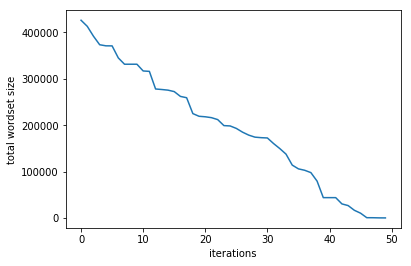

In [12]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(progress))), progress, '-')
plt.xlabel('iterations')
plt.ylabel('total wordset size')

## Exporting

In [13]:
from exporter import Exporter
        

In [14]:
Exporter.Export('test.xml', solved)

<puzzle><author>Luka van der Plas</author><size>13x13</size><grid><row>guimpe_cabble</row><row>u_fulk_lleu_r</row><row>am_mortify_ai</row><row>syd_torma_ilk</row><row>ates_nib_idea</row><row>_h_ka_a_us_c_</row><row>moderatorship</row><row>_p_ex_o_ne_t_</row><row>mool_ama_ichu</row><row>new_erizo_aam</row><row>em_sanctus_la</row><row>m_apse_ecru_u</row><row>ensate_chidra</row></grid></puzzle>
